In [1]:
%matplotlib inline

This module is very similar to the module "blobs_per_cell" and the project is the same, determine the amount of "blobs" per cells. However, here I want to find the amont of blobs in cells injected with a specific construct and compare it with the "non-injected cells". Also, unfortunately, I didn't have any clear marker to count the cells, so I worte a little class to count them "manually".

## 1. Import the modules we will need

In [2]:
import open_image_bioformat as oib
import blobs_per_cell_click as bpcc

## 2. Load the images

Using the oib.batch_analysis_bioformat, I open and read, using python-bioformat, all the images located in the "path" and return a list of numpy array.

In [3]:
path = ".../.../..."
image_blob, im = oib.batch_analysis_bioformat(path)

## 3. Visualyse the images
### a. Take a look at all the different channels

First, I want to find in which channel I've the injected cells and where do I have my marker of interest for counting the blobs:

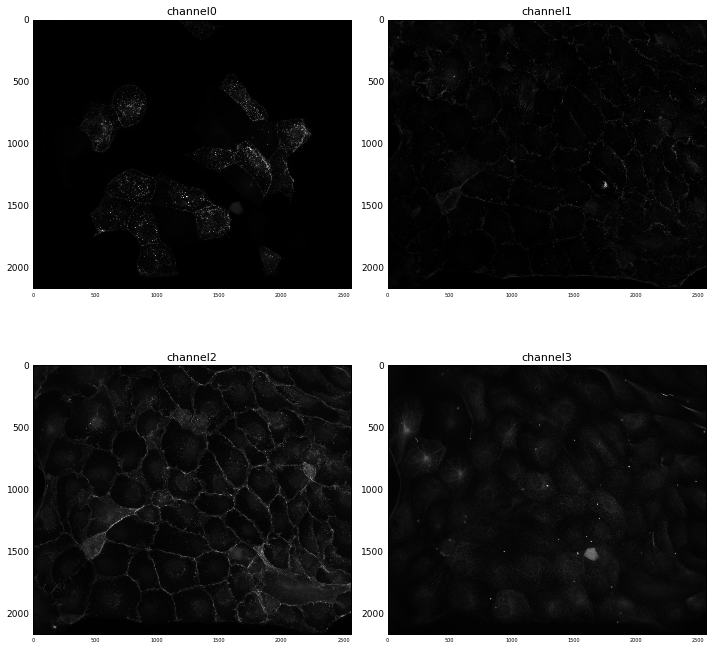

In [10]:
oib.split_channels(image_blob[0], path, im)

### b. Verify the histograms 
The injected cells are in channel0 and channel2 is where I want to measure the amount of blobs. I can then check the histogram for these 2 channels for all the different images in path using oib.show_series_all_histo:

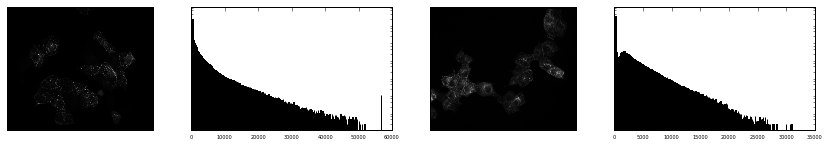

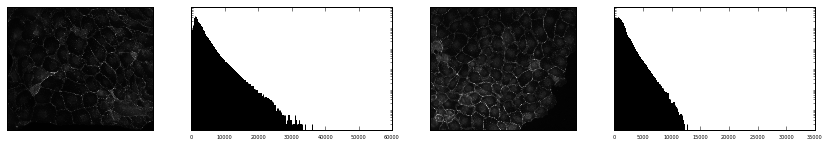

In [5]:
oib.show_series_all_histo(image_blob, im, channel = 'channel0')
oib.show_series_all_histo(image_blob, im, channel = 'channel2')

Unfortunately the signal in channel2 is pretty weak which might make it hard to find the blobs in the image.

## 4. Create a Mask
To get the amount of blobs in injected cells I need to create a mask for this channel but first I need to define where to look for injected cells (channel0) and "counting blobs" (channel2):

In [6]:
channel1, channel2 = bpcc.define_ch1_ch2(image_blob[0], im, channel1 = "channel2", channel2 = "channel0")
channel1_channel2, channel2_thresh = bpcc.mask_numpy_array(channel1, channel2, thresh_o = 90)

## 5. Image processing
The signal in channel2 is not very clean and pretty weak, to be able to find the spots or blobs without too much error I need to do some image processing:

In [7]:
image_conv = bpcc.image_processing(channel1)

## 6. Find the blobs
The signal in channel2 is not very clean and pretty weak, to be able to find the spots or blobs without too much error I need to do some image processing:

In [8]:
blob_in_image_after_binary, blob_only_in_channel2, blob_not_in_channel2 = bpcc.blobs(image_conv, channel1_channel2, remove_mb = True, val = 160, size = 100)

## 7. Show result

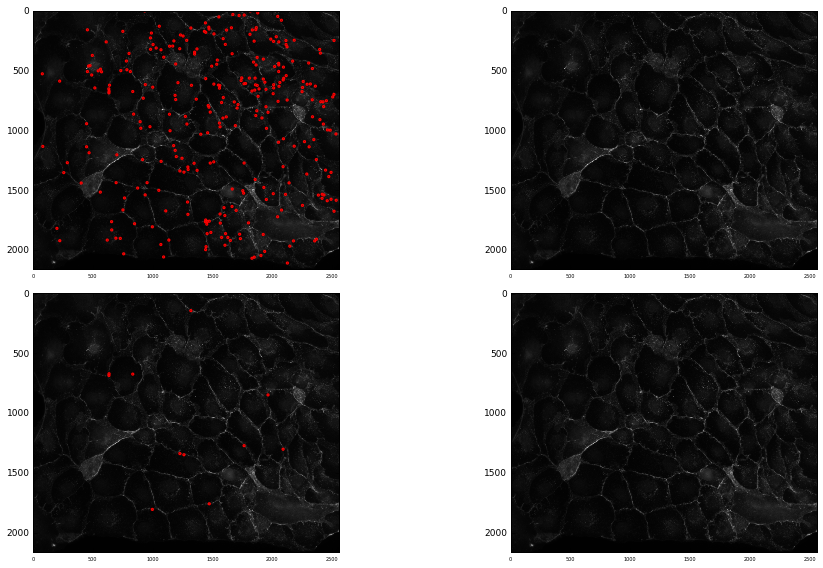

In [9]:
bpcc.show_result(blob_in_image_after_binary, blob_only_in_channel2, blob_not_in_channel2, channel1)

## 8. Image processing
To be able to count the cells I wrote a little class which allow to record left click (yellow dots) as total amount of cells and right click (red dots) as injected cells. bpcc.numbercell will return a list of left click and right click. 

<IPython.core.display.Javascript object>


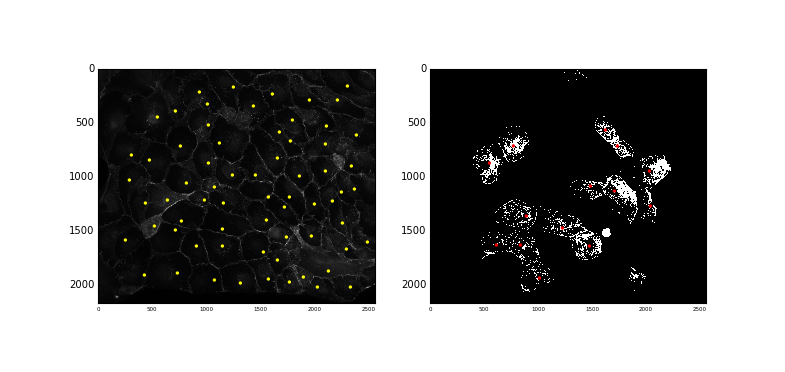

In [12]:
%matplotlib notebook
count = bpcc.numbercell(channel1, channel2_thresh)

In [13]:
numb_cells_inj, numb_cells_tot = count.getnumbcells()
print numb_cells_inj
print numb_cells_tot

14
67


## 9. Batch processing

<IPython.core.display.Javascript object>


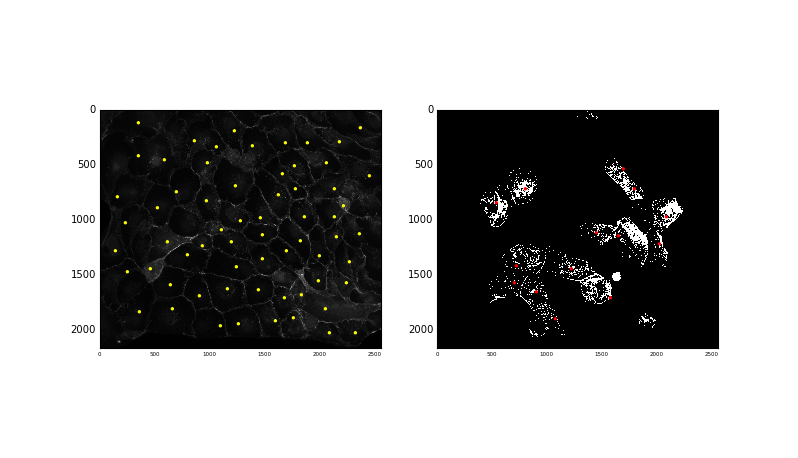

<IPython.core.display.Javascript object>


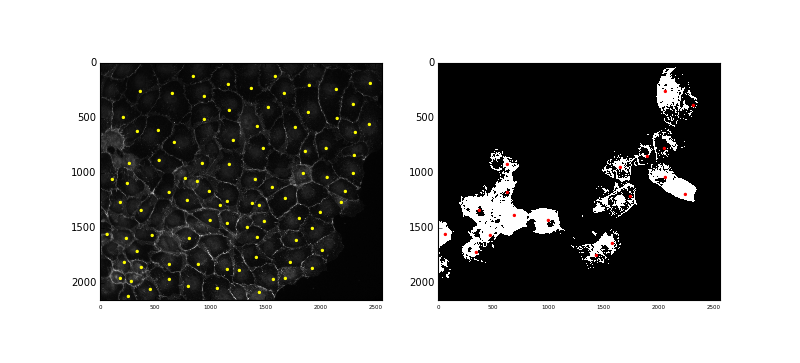

In [14]:
count = {}

for x in range(len(image_blob)):
    
    channel1, channel2 = bpcc.define_ch1_ch2(image_blob[x], im, channel1 = "channel2", channel2 = "channel0")
    channel1_channel2, channel2_thresh = bpcc.mask_numpy_array(channel1, channel2, thresh_o = 90)
    image_conv = bpcc.image_processing(channel1)
    blob_in_image_after_binary, blob_only_in_channel2, blob_not_in_channel2 = bpcc.blobs(image_conv, channel1_channel2, remove_mb = True, val = 160, size = 100)
    count["img{0}".format(x)]=bpcc.numbercell(channel1, channel2_thresh)


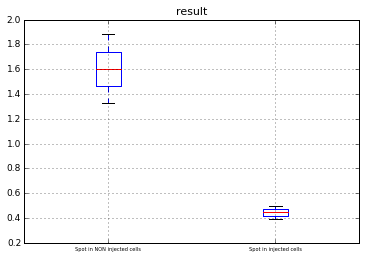

In [17]:
%matplotlib inline

import pandas as pd

result={'Spot in injected cells':[],'Spot in NON injected cells':[]}

for x in range(len(count)):
   
    numb_cells_inj, numb_cells_tot = count['img%d' % (x)].getnumbcells()   
    blob_in_channel2 = float(len(blob_only_in_channel2)) / float(numb_cells_inj)
    blob_not_in_channel2 = float((len(blob_in_image_after_binary) - len(blob_only_in_channel2))) / float(numb_cells_tot-numb_cells_inj)
    result['Spot in injected cells'].append(blob_in_channel2)
    result['Spot in NON injected cells'].append(blob_not_in_channel2)
    
df = pd.DataFrame(result)
df.plot(kind='box', title = "result", figsize=(6, 4))